In [ ]:
# Block 0: Mount your Google Drive
import torch
from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cpu


Loaded raw dataset shape: (20000, 25)

All Genre Counts (raw):
Drama              6133
Comedy             3978
Documentary        3534
Romance            2025
Action             1765
Thriller           1670
Horror             1455
Animation          1275
Crime              1265
Music              1239
TV Movie           1121
Family              954
Adventure           688
Science Fiction     671
Fantasy             659
Mystery             571
History             449
War                 265
Western              73
dtype: int64

Logical Rationale:
We selected the following common genres (in blue) because they are widely produced, have broad audience appeal, and are suitable for a mass market including children and families:
['Drama', 'Comedy', 'Documentary', 'Romance', 'Action', 'Thriller', 'Horror', 'Crime', 'Music', 'Animation', 'TV Movie', 'Family']

The following genres are excluded (in red) because they are either niche or have lower watchership according to our dataset, making them

<ipython-input-3-dddb554a9d5b>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_genres_counts.index, y=all_genres_counts.values, palette=colors, edgecolor='black')


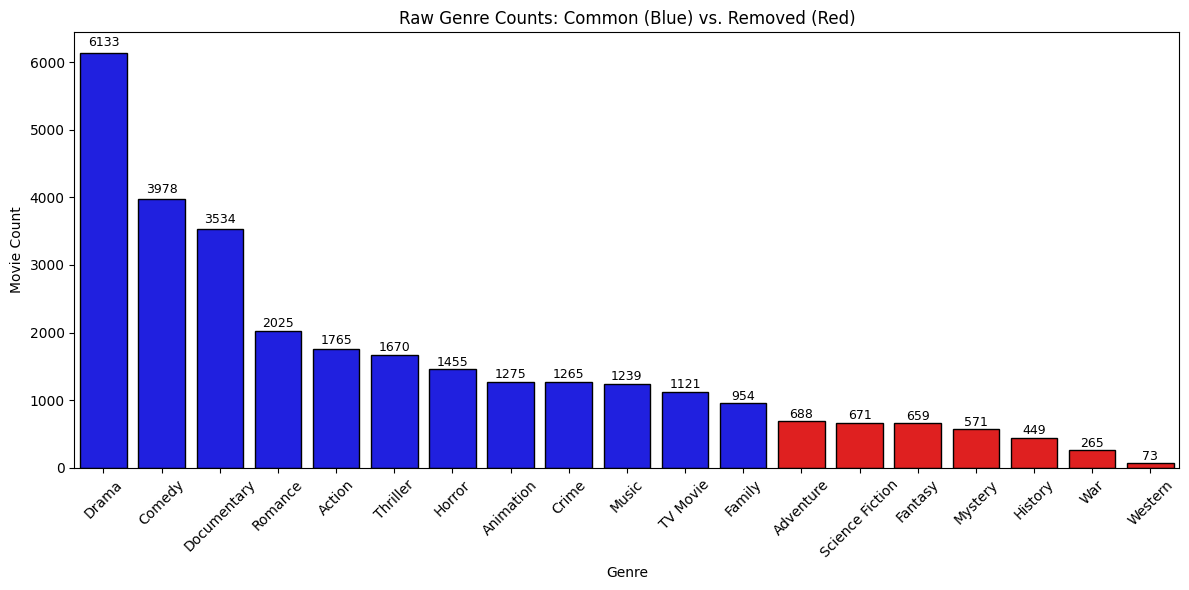

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# 1) Load the Raw CSV File
# ------------------------------
file_path = '/content/drive/MyDrive/Tmdb_posters_custom/movie_metadata_from TMDB API.csv'
df_raw = pd.read_csv(file_path)
print("Loaded raw dataset shape:", df_raw.shape)

# ------------------------------
# 2) Process the 'genres' Column
# ------------------------------
# Often, the genres are stored as a string representation of a list.
def safe_convert(x):
    try:
        return eval(x)
    except:
        return []

df_raw['genres'] = df_raw['genres'].apply(safe_convert)

# ------------------------------
# 3) Compute Genre Counts for ALL Genres (before filtering)
# ------------------------------
genre_counts_all = {}
for genre_list in df_raw['genres']:
    for g in genre_list:
        genre_counts_all[g] = genre_counts_all.get(g, 0) + 1

all_genres_counts = pd.Series(genre_counts_all).sort_values(ascending=False)
print("\nAll Genre Counts (raw):")
print(all_genres_counts)

# ------------------------------
# 4) Define the Target (Common) Genres and Determine Removed Genres
# ------------------------------
# We want to focus on mainstream and widely watched genres,
# for instance, those suitable for children and the mass population.
# Here, we intentionally filter out niche genres such as Adventure, Fantasy,
# Science Fiction, History, Mystery, War, Western, etc.
common_genres = ['Drama', 'Comedy', 'Documentary', 'Romance',
                 'Action', 'Thriller', 'Horror', 'Crime',
                 'Music', 'Animation', 'TV Movie', 'Family']

# Identify genres that are in the raw counts but are not in our common_genres list.
removed_genres = [g for g in all_genres_counts.index if g not in common_genres]

print("\nLogical Rationale:")
print("We selected the following common genres (in blue) because they are widely produced, have broad audience appeal, and are suitable for a mass market including children and families:")
print(common_genres)
print("\nThe following genres are excluded (in red) because they are either niche or have lower watchership according to our dataset, making them less suitable for our primary analysis:")
print(removed_genres)

# ------------------------------
# 5) Create a Bar Chart to Visualize the Raw Genre Distribution
# ------------------------------
# Prepare color coding: common genres in blue; removed genres in red.
colors = []
for genre in all_genres_counts.index:
    if genre in common_genres:
        colors.append('blue')
    else:
        colors.append('red')

plt.figure(figsize=(12,6))
sns.barplot(x=all_genres_counts.index, y=all_genres_counts.values, palette=colors, edgecolor='black')
plt.title("Raw Genre Counts: Common (Blue) vs. Removed (Red)")
plt.xlabel("Genre")
plt.ylabel("Movie Count")
plt.xticks(rotation=45)

# Annotate each bar with its count value.
for i, (genre, count) in enumerate(all_genres_counts.items()):
    plt.text(i, count + (count * 0.01), str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# Combined Pipeline: CB1 to CB5
# This block mounts Google Drive, checks if the final CSV exists, and if not, runs the entire data collection and processing pipeline.
# The pipeline performs the following:
#   CB1: Environment Setup, Genre Mapping & Target Definitions
#   CB2: Fetch Movies Stratified by Genre using TMDB API
#   CB3: Combine and Deduplicate Movies, merging genre lists for multi-label movies
#   CB4: Download Poster Images for Each Movie
#   CB5: One-Hot Encode Genre Labels and Save the Final Balanced CSV

# -------------------------
# Block: Mount Drive
# -------------------------
from google.colab import drive
drive.mount('/content/drive')

# -------------------------
# Block CB1: Setup Environment, Paths, and Genre Definitions
# -------------------------
import os
import requests
import pandas as pd

# Define a new base folder to preserve this custom dataset (won't override previous data)
base_dataset_dir = '/content/drive/MyDrive/Tmdb_posters_custom'
if not os.path.exists(base_dataset_dir):
    os.makedirs(base_dataset_dir)

# Define file paths for the final CSV and the poster folder
custom_csv_path = os.path.join(base_dataset_dir, 'custom_balanced_movie_metadata.csv')
custom_poster_dir = os.path.join(base_dataset_dir, 'movie_posters')
if not os.path.exists(custom_poster_dir):
    os.makedirs(custom_poster_dir)

# Define the target genres we want to work with.
# These genres were selected because they are widely popular and suitable for a mass audience (including children and families).
common_genres = ['Drama', 'Comedy', 'Documentary', 'Romance',
                 'Action', 'Thriller', 'Horror', 'Crime',
                 'Music', 'Animation', 'TV Movie', 'Family']

# TMDB API key (replace with your own key if necessary)
API_KEY = 'd987d81a646fa33f4795a26f25fe7851'

# Fetch the genre list from the TMDB API
genres_url = f'https://api.themoviedb.org/3/genre/movie/list?api_key={API_KEY}'
genres_response = requests.get(genres_url)
genres_json = genres_response.json()
if 'genres' not in genres_json:
    raise Exception("Failed to fetch genres; please verify your API key and internet connectivity.")

# Create genre mapping dictionaries:
#   - genre_map: maps TMDB genre id to genre name
#   - genre_map_inv: inverse mapping from genre name to id
genre_map = {g['id']: g['name'] for g in genres_json['genres']}
genre_map_inv = {v: k for k, v in genre_map.items()}

print("Fetched TMDB Genre Mapping:")
print(genre_map)
print("\nTarget Common Genres:")
print(common_genres)

# Set desired sample count limits per genre (for stratified fetch)
min_count = 2500
max_count = 3500
print(f"\nDesired movie count per genre: between {min_count} and {max_count}")

# -------------------------
# Check if the final CSV already exists; if so, load and skip the pipeline
# -------------------------
if os.path.exists(custom_csv_path):
    print("\nFinal custom balanced movie metadata CSV already exists. Loading data...")
    df_final = pd.read_csv(custom_csv_path)
    print(f"Loaded dataset shape: {df_final.shape}")
else:
    print("\nFinal CSV not found. Running full pipeline (CB1 to CB5)...")

    # -------------------------
    # Block CB2: Fetch Movies Stratified by Genre
    # -------------------------
    import time
    from tqdm import tqdm

    # Initialize a dictionary to store movies for each genre
    movies_by_genre = {genre: [] for genre in common_genres}

    # Loop over each target genre and fetch movies using the TMDB Discover API
    for genre in common_genres:
        genre_id = genre_map_inv.get(genre)
        print(f"\nFetching movies for genre: {genre} (ID: {genre_id})")
        page = 1
        while len(movies_by_genre[genre]) < max_count:
            discover_url = (
                f"https://api.themoviedb.org/3/discover/movie?api_key={API_KEY}"
                f"&language=en-US&sort_by=popularity.desc&include_adult=false"
                f"&include_video=false&with_genres={genre_id}&page={page}"
            )
            response = requests.get(discover_url)
            data = response.json()
            if 'results' not in data or len(data['results']) == 0:
                print(f"No more results for genre '{genre}' on page {page}.")
                break
            for movie in data['results']:
                # Only accept movies with a valid overview and poster path
                if movie.get('overview') and movie.get('poster_path'):
                    movie['source_genre'] = genre  # Tag the movie with its query genre
                    movies_by_genre[genre].append(movie)
                    if len(movies_by_genre[genre]) >= max_count:
                        break
            print(f"Genre '{genre}': Collected {len(movies_by_genre[genre])} movies (page {page})")
            page += 1
            time.sleep(0.25)  # Brief pause to prevent API rate limiting
        if len(movies_by_genre[genre]) < min_count:
            print(f"Warning: Only {len(movies_by_genre[genre])} movies found for genre '{genre}' (< min_count).")

    # Print final count per genre for verification
    for genre in common_genres:
        print(f"{genre}: {len(movies_by_genre[genre])} movies")

    # -------------------------
    # Block CB3: Combine and Deduplicate Movies
    # -------------------------
    # Combine movies from all genres
    all_movies_list = []
    for genre in common_genres:
        all_movies_list.extend(movies_by_genre[genre])

    print(f"\nTotal movies collected before deduplication: {len(all_movies_list)}")

    # Ensure every movie dictionary has a 'genres' key (if missing, fill using 'genre_ids')
    for movie in all_movies_list:
        if 'genres' not in movie:
            if 'genre_ids' in movie and isinstance(movie.get('genre_ids'), list):
                movie['genres'] = [genre_map.get(gid, 'Unknown') for gid in movie.get('genre_ids', [])]
            else:
                movie['genres'] = []

    # Create a DataFrame from the combined list
    df_raw = pd.DataFrame(all_movies_list)

    # Function to combine genres from duplicate entries (using set union)
    def combine_genres(genres_series):
        merged = set()
        for genres in genres_series:
            if isinstance(genres, list):
                merged.update(genres)
        return list(merged)

    # Group by movie 'id', taking the first appearance of text fields, and merge genre lists
    df_grouped = df_raw.groupby('id').agg({
        'title': 'first',
        'overview': 'first',
        'poster_path': 'first',
        'source_genre': lambda x: list(set(x)),
        'genres': lambda x: combine_genres(x)
    }).reset_index()

    df_grouped.rename(columns={'id': 'movie_id'}, inplace=True)
    print(f"Dataset shape after deduplication: {df_grouped.shape}")

    # -------------------------
    # Block CB4: Download Posters
    # -------------------------
    from tqdm import tqdm
    import requests

    os.makedirs(custom_poster_dir, exist_ok=True)

    # Function to download a poster image for a given movie
    def download_poster(movie):
        base_url = "https://image.tmdb.org/t/p/w500"
        poster_path = movie.get('poster_path')
        if poster_path:
            full_url = base_url + poster_path
            target_file = os.path.join(custom_poster_dir, f"{movie['movie_id']}.jpg")
            try:
                r = requests.get(full_url, timeout=10)
                if r.status_code == 200:
                    with open(target_file, 'wb') as f:
                        f.write(r.content)
                    return target_file
                else:
                    return None
            except Exception as e:
                print(f"Error downloading poster for movie {movie['movie_id']}: {e}")
                return None
        return None

    # Download posters and save path to column 'poster_file'
    df_grouped['poster_file'] = df_grouped.apply(lambda row: download_poster(row), axis=1)
    print("Poster downloading completed.")

    # -------------------------
    # Block CB5: One-Hot Encode Genre Labels and Save Final CSV
    # -------------------------
    from sklearn.preprocessing import MultiLabelBinarizer

    mlb = MultiLabelBinarizer(classes=common_genres)
    genre_matrix = mlb.fit_transform(df_grouped['genres'])
    genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_)

    # Concatenate the one-hot encoded DataFrame with df_grouped
    df_final = pd.concat([df_grouped, genre_df], axis=1)

    # Save the final custom balanced movie metadata CSV to disk
    df_final.to_csv(custom_csv_path, index=False)
    print(f"Final custom balanced movie metadata CSV saved to: {custom_csv_path}")

    # Optionally, print final genre distribution
    final_counts = df_final[common_genres].sum().sort_values(ascending=False)
    print("\nFinal Genre Distribution:")
    print(final_counts)

# -------------------------
# Checkpoint Complete:
# At this point, df_final, common_genres, mlb, and final_counts are available for subsequent analysis and EDA.
print("\nCheckpoint complete. All key variables are loaded for further analysis and model training.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fetched TMDB Genre Mapping:
{28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy', 80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family', 14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music', 9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction', 10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'}

Target Common Genres:
['Drama', 'Comedy', 'Documentary', 'Romance', 'Action', 'Thriller', 'Horror', 'Crime', 'Music', 'Animation', 'TV Movie', 'Family']

Desired movie count per genre: between 2500 and 3500

Final custom balanced movie metadata CSV already exists. Loading data...
Loaded dataset shape: (27901, 19)

Checkpoint complete. All key variables are loaded for further analysis and model training.


In [ ]:
# Block E1: Basic Dataset Overview and Cleaning Metrics

import pandas as pd

# Load the final CSV saved from Block CB5 (update the path if needed)
final_csv_path = '/content/drive/MyDrive/Tmdb_posters_custom/custom_balanced_movie_metadata.csv'
df_final = pd.read_csv(final_csv_path)

print("Final Dataset Overview:")
print("-------------------------")
print(f"Total records: {len(df_final)}")
print("\nDataFrame Info:")
df_final.info()
print("\nMissing Values per Column:")
print(df_final.isnull().sum())
print("\nNumber of Duplicate Rows:", df_final.duplicated().sum())
print("\nSample Rows:")
print(df_final.head(5))


Final Dataset Overview:
-------------------------
Total records: 27901

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movie_id      27901 non-null  int64 
 1   title         27901 non-null  object
 2   overview      27901 non-null  object
 3   poster_path   27901 non-null  object
 4   source_genre  27901 non-null  object
 5   genres        27901 non-null  object
 6   poster_file   27901 non-null  object
 7   Drama         27901 non-null  int64 
 8   Comedy        27901 non-null  int64 
 9   Documentary   27901 non-null  int64 
 10  Romance       27901 non-null  int64 
 11  Action        27901 non-null  int64 
 12  Thriller      27901 non-null  int64 
 13  Horror        27901 non-null  int64 
 14  Crime         27901 non-null  int64 
 15  Music         27901 non-null  int64 
 16  Animation     27901 non-null  int64 
 17  

In [ ]:
# Checkpoint: Load Final Custom Balanced Dataset and Setup Variables for EDA

import os
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# --- Step 2: Define the file path and common genres ---
# Update the path if needed (this should be the same as used in CB1-CB5)
custom_csv_path = '/content/drive/MyDrive/Tmdb_posters_custom/custom_balanced_movie_metadata.csv'

# Define common_genres (make sure this is the same list used earlier)
common_genres = ['Drama', 'Comedy', 'Documentary', 'Romance',
                 'Action', 'Thriller', 'Horror', 'Crime',
                 'Music', 'Animation', 'TV Movie', 'Family']

# --- Step 3: Load the Final Balanced CSV ---
if os.path.exists(custom_csv_path):
    print("Final custom balanced movie metadata CSV found. Loading data...")
    df_final = pd.read_csv(custom_csv_path)
    print(f"Loaded dataset shape: {df_final.shape}")
else:
    raise FileNotFoundError("Final balanced CSV not found. Please run Blocks CB1–CB5 first.")

# --- Step 4: Check for One-Hot Encoded Genre Columns ---
# We expect that the final CSV contains one-hot encoded columns corresponding to common_genres.
missing_genre_cols = [genre for genre in common_genres if genre not in df_final.columns]
if missing_genre_cols:
    print("The following genre columns are missing:", missing_genre_cols)
    print("Re-creating one-hot encoded genre columns from 'genres' column...")
    # Ensure the 'genres' column is a list (if stored as a string, we attempt evaluation)
    def safe_convert(x):
        if isinstance(x, str):
            try:
                return eval(x)
            except:
                return []
        return x
    df_final['genres'] = df_final['genres'].apply(safe_convert)

    mlb = MultiLabelBinarizer(classes=common_genres)
    genre_matrix = mlb.fit_transform(df_final['genres'])
    genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_)
    df_final = pd.concat([df_final, genre_df], axis=1)
    print("One-hot encoding complete.")
else:
    print("One-hot encoded genre columns exist.")
    # Optionally, create an instance of MultiLabelBinarizer for later use in EDA.
    mlb = MultiLabelBinarizer(classes=common_genres)

# --- Step 5: Compute Final Genre Distribution and Print Evaluation Metrics ---
final_counts = df_final[common_genres].sum().sort_values(ascending=False)
print("\nFinal Genre Distribution:")
print(final_counts)

# Save final_counts to a variable for use in EDA blocks
# (You can now directly reference df_final, common_genres, mlb, and final_counts in subsequent analyses)
print("\nCheckpoint complete. All key variables are loaded for EDA.")


Final custom balanced movie metadata CSV found. Loading data...
Loaded dataset shape: (27901, 19)
One-hot encoded genre columns exist.

Final Genre Distribution:
Drama          9907
Comedy         7726
Thriller       5652
Action         5190
Romance        5092
Family         3997
Crime          3953
Horror         3888
Documentary    3832
Animation      3658
TV Movie       3626
Music          3490
dtype: int64

Checkpoint complete. All key variables are loaded for EDA.


In [ ]:
# Block E3: Genre Distribution – Descriptive Statistics

import numpy as np
import scipy.stats as stats

# Define common_genres (if not already defined)
common_genres = ['Drama', 'Comedy', 'Documentary', 'Romance',
                 'Action', 'Thriller', 'Horror', 'Crime',
                 'Music', 'Animation', 'TV Movie', 'Family']

# # Calculate final genre counts
# final_counts = df_final[common_genres].sum().sort_values(ascending=False)
# print("Final Genre Distribution:")
# print(final_counts)

# Compute evaluation metrics for genre counts
mean_genres = final_counts.mean()
median_genres = final_counts.median()
std_genres = final_counts.std()
skew_genres = stats.skew(final_counts.values, bias=False)
kurtosis_genres = stats.kurtosis(final_counts.values, fisher=True)
min_genres = final_counts.min()
max_genres = final_counts.max()
iqr_genres = np.percentile(final_counts, 75) - np.percentile(final_counts, 25)

print("\nGenre Count Evaluation Metrics:")
print(f"Mean: {mean_genres:.2f}")
print(f"Median: {median_genres:.2f}")
print(f"Standard Deviation: {std_genres:.2f}")
print(f"Skewness: {skew_genres:.2f}")
print(f"Kurtosis: {kurtosis_genres:.2f}")
print(f"Min: {min_genres}")
print(f"Max: {max_genres}")
print(f"IQR: {iqr_genres:.2f}")



Genre Count Evaluation Metrics:
Mean: 5000.92
Median: 3975.00
Standard Deviation: 1969.11
Skewness: 1.79
Kurtosis: 1.30
Min: 3490
Max: 9907
IQR: 1517.00


<ipython-input-8-a0118e0a49ee>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_counts.index, y=final_counts.values, palette='viridis')


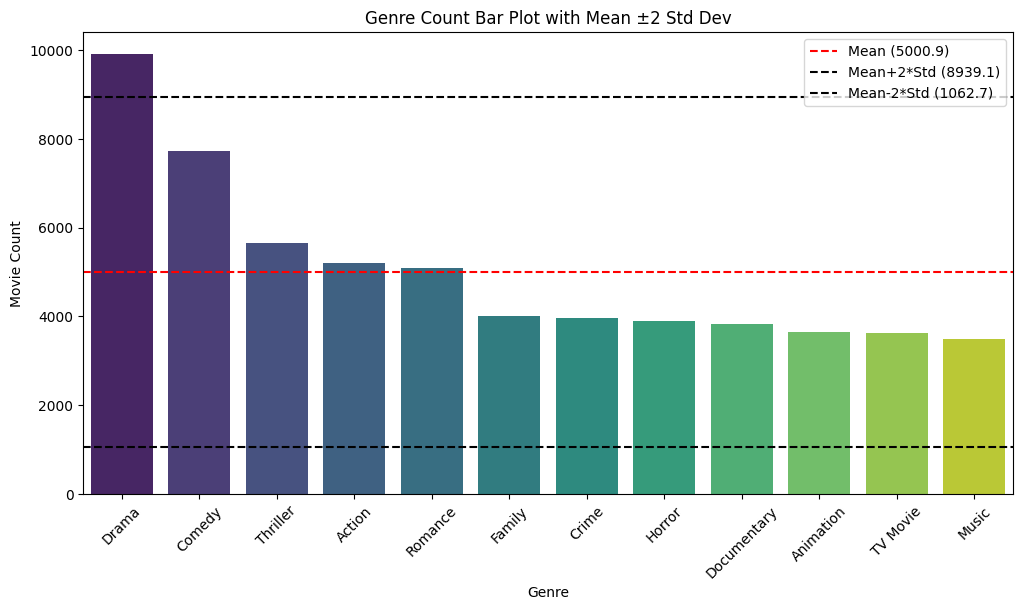

In [ ]:
# Block E4: Genre Count Bar Plot with Normal Overlays
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(x=final_counts.index, y=final_counts.values, palette='viridis')
plt.axhline(mean_genres, color='red', linestyle='--', label=f'Mean ({mean_genres:.1f})')
plt.axhline(mean_genres + 2*std_genres, color='black', linestyle='--', label=f'Mean+2*Std ({mean_genres+2*std_genres:.1f})')
plt.axhline(mean_genres - 2*std_genres, color='black', linestyle='--', label=f'Mean-2*Std ({mean_genres-2*std_genres:.1f})')
plt.title("Genre Count Bar Plot with Mean ±2 Std Dev")
plt.xlabel("Genre")
plt.ylabel("Movie Count")
plt.xticks(rotation=45)
plt.legend()
plt.show()


Additional Metadata Cleaning Metrics:
Missing overviews: 0
Missing titles: 0
Duplicate movie_id count: 0

Title Length Statistics:
count    27901.000000
mean        18.915630
std         11.863032
min          1.000000
25%         11.000000
50%         16.000000
75%         24.000000
max        150.000000
Name: title_length, dtype: float64


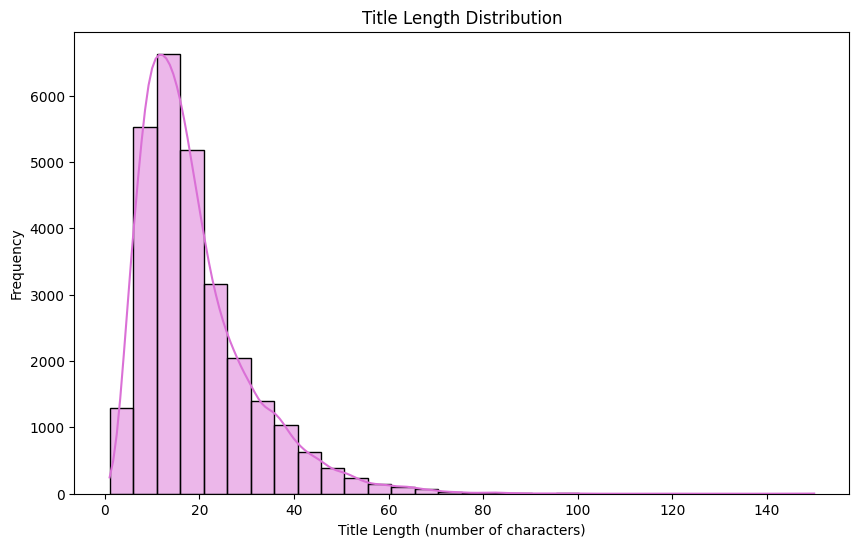

In [ ]:
# Block E8: Additional Metadata Quality Metrics (Text)

# Count of missing overviews and titles
missing_overviews = df_final['overview'].isnull().sum()
missing_titles = df_final['title'].isnull().sum()

# Duplicate count based on movie_id (should be 0 after deduplication)
duplicate_count = df_final.duplicated(subset=['movie_id']).sum()

# Title length distribution
df_final['title_length'] = df_final['title'].apply(lambda x: len(str(x)))
title_stats = df_final['title_length'].describe()

print("Additional Metadata Cleaning Metrics:")
print(f"Missing overviews: {missing_overviews}")
print(f"Missing titles: {missing_titles}")
print(f"Duplicate movie_id count: {duplicate_count}")
print("\nTitle Length Statistics:")
print(title_stats)

# Plot title length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_final['title_length'], bins=30, kde=True, color='orchid', edgecolor='black')
plt.title("Title Length Distribution")
plt.xlabel("Title Length (number of characters)")
plt.ylabel("Frequency")
plt.show()


Overview Length Evaluation Metrics:
Mean: 48.42
Median: 41.00
Standard Deviation: 28.08
Skewness: 1.35
Kurtosis: 2.12
Min: 1
Max: 186
IQR: 36.00


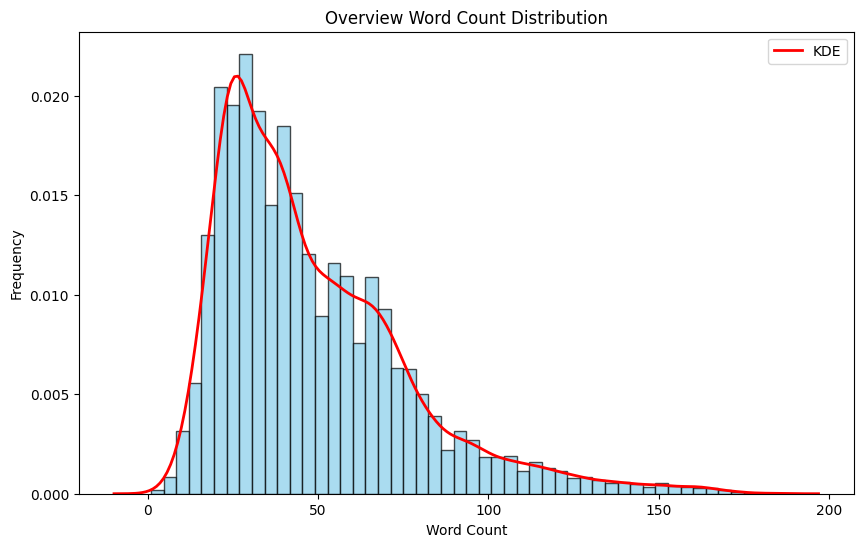

In [ ]:
# Block E2: Overview (Text) Length Analysis

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# If not already present, calculate overview word count.
if 'overview_word_count' not in df_final.columns:
    df_final['overview_word_count'] = df_final['overview'].apply(lambda x: len(str(x).split()))

overview_lengths = df_final['overview_word_count']

# Evaluation metrics
mean_len = overview_lengths.mean()
median_len = overview_lengths.median()
std_len = overview_lengths.std()
skew_len = stats.skew(overview_lengths, bias=False)
kurtosis_len = stats.kurtosis(overview_lengths, fisher=True)
min_len = overview_lengths.min()
max_len = overview_lengths.max()
iqr_len = np.percentile(overview_lengths, 75) - np.percentile(overview_lengths, 25)

print("Overview Length Evaluation Metrics:")
print(f"Mean: {mean_len:.2f}")
print(f"Median: {median_len:.2f}")
print(f"Standard Deviation: {std_len:.2f}")
print(f"Skewness: {skew_len:.2f}")
print(f"Kurtosis: {kurtosis_len:.2f}")
print(f"Min: {min_len}")
print(f"Max: {max_len}")
print(f"IQR: {iqr_len:.2f}")

# Plot histogram with KDE for overview lengths
plt.figure(figsize=(10, 6))
plt.title("Overview Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.hist(overview_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7, density=True)
sns.kdeplot(overview_lengths, color='red', lw=2, label="KDE")
plt.legend()
plt.show()


Number of genres per movie statistics:
count    27901.000000
mean         2.150855
std          0.882528
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: num_genres, dtype: float64


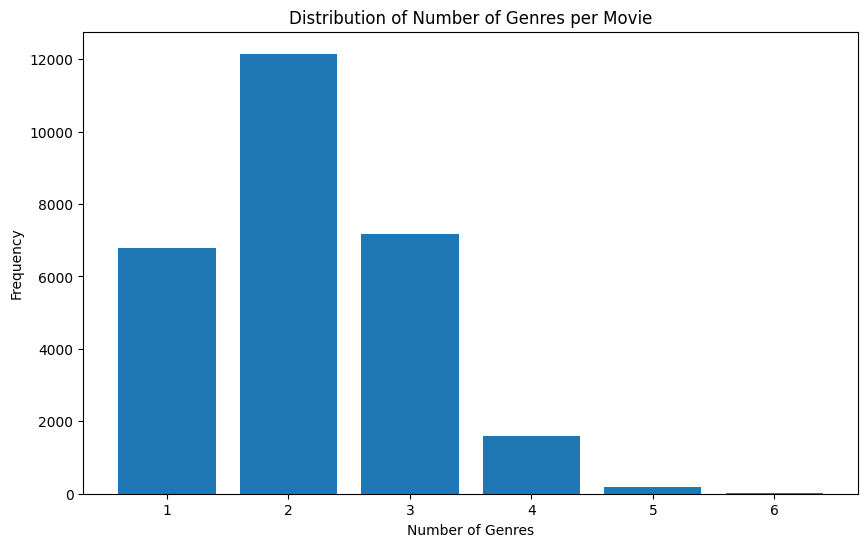

In [ ]:
# Enhanced EDA: Number of Genres per Movie
import matplotlib.pyplot as plt

# Calculate number of genres per movie
df_final['num_genres'] = df_final[common_genres].sum(axis=1)

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(df_final['num_genres'], bins=range(1, df_final['num_genres'].max()+2), align='left', rwidth=0.8)
plt.title('Distribution of Number of Genres per Movie')
plt.xlabel('Number of Genres')
plt.ylabel('Frequency')
plt.xticks(range(1, df_final['num_genres'].max()+1))
plt.savefig('num_genres_histogram.png')

# Print statistics
print("Number of genres per movie statistics:")
print(df_final['num_genres'].describe())

# Enhanced EDA: Genre Co-occurrence Matrix
import seaborn as sns

# Compute co-occurrence matrix
co_occurrence = df_final[common_genres].T.dot(df_final[common_genres])


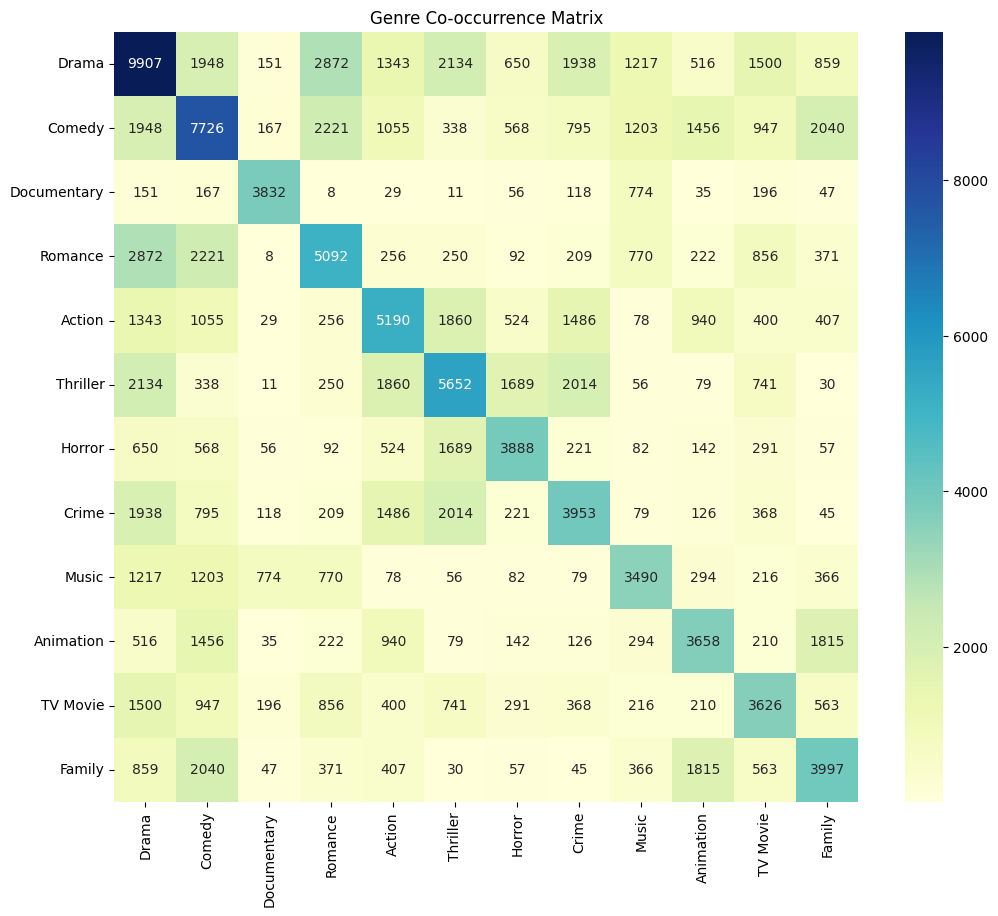

In [ ]:
# Plot heatmap showing relation between genres
plt.figure(figsize=(12,10))
sns.heatmap(co_occurrence, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Genre Co-occurrence Matrix')
plt.savefig('genre_cooccurrence_heatmap.png')

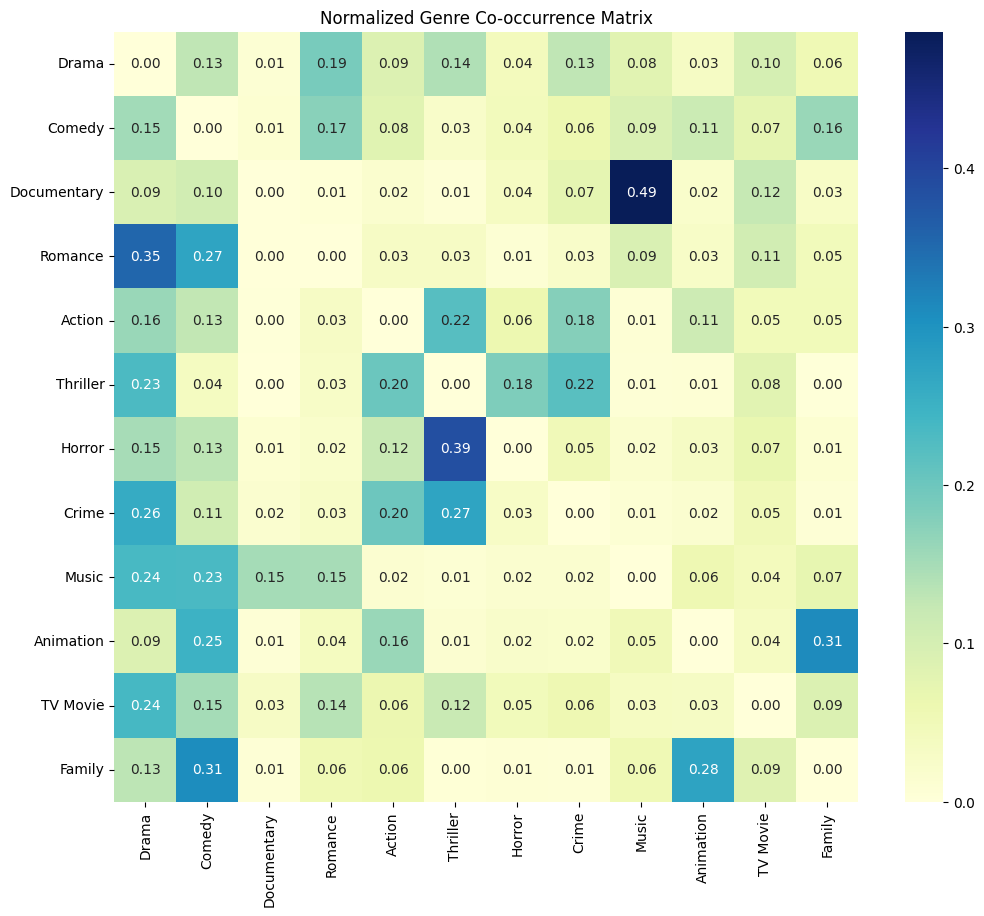

In [ ]:
# 3. Extended Genre Co-occurrence Matrix with Normalization
co_occurrence = df_final[common_genres].T.dot(df_final[common_genres])
np.fill_diagonal(co_occurrence.values, 0)  # Remove self-co-occurrences
co_occurrence_normalized = co_occurrence.div(co_occurrence.sum(axis=1), axis=0)
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_normalized, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Normalized Genre Co-occurrence Matrix')
plt.savefig('normalized_genre_cooccurrence.png')

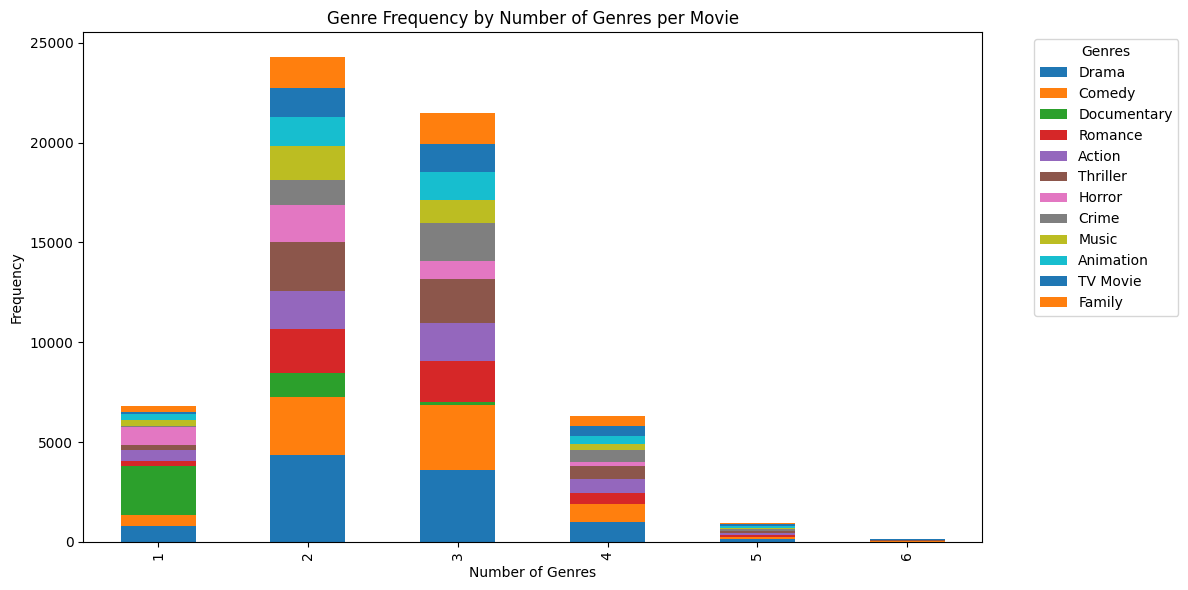

In [ ]:
import matplotlib.pyplot as plt
#Shows mapping frequency of movies in genres  there
genre_freq_by_count = df_final.groupby('num_genres')[common_genres].sum()
genre_freq_by_count.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Genre Frequency by Number of Genres per Movie')
plt.xlabel('Number of Genres')
plt.ylabel('Frequency')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('genre_freq_by_count.png')

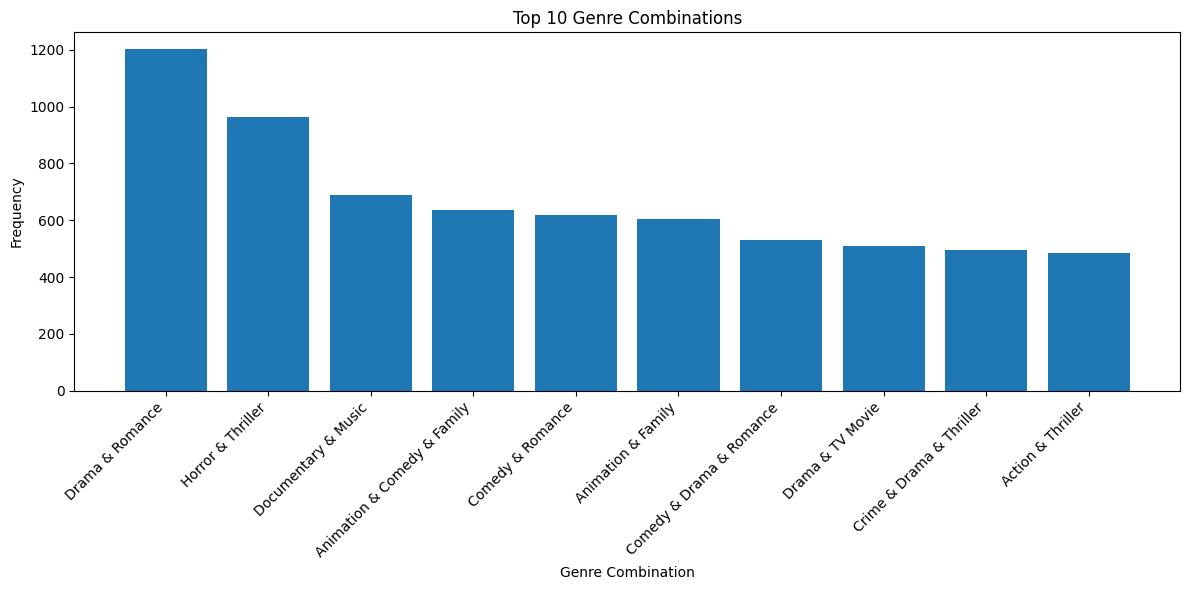

In [ ]:
# 5. Top Genre Combinations with Frequency
from collections import Counter
genre_combos = df_final[df_final[common_genres].sum(axis=1) > 1].apply(
    lambda row: tuple(sorted([genre for genre in common_genres if row[genre] == 1])), axis=1)
combo_counts = Counter(genre_combos)
N = 10
top_combos = combo_counts.most_common(N)
combo_labels = [' & '.join(combo) for combo, _ in top_combos]
combo_freqs = [freq for _, freq in top_combos]
plt.figure(figsize=(12, 6))
plt.bar(combo_labels, combo_freqs)
plt.title(f'Top {N} Genre Combinations')
plt.xlabel('Genre Combination')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_genre_combinations.png')

In [ ]:
# Block E8: Identify Overrepresented Genres for Potential Downsampling

threshold = mean_genres + std_genres  # you might choose a different threshold
overrepresented = final_counts[final_counts > threshold]
print("Overrepresented Genres (Count > Mean + 1*Std):")
print(overrepresented)

# As a recommendation: these genres might be candidates for downsampling
if not overrepresented.empty:
    print("\nRecommendation: Consider downsampling these genres during training to reduce bias.")
else:
    print("\nNo genres are significantly overrepresented based on the chosen threshold.")


Overrepresented Genres (Count > Mean + 1*Std):
Drama     9907
Comedy    7726
dtype: int64

Recommendation: Consider downsampling these genres during training to reduce bias.


In [ ]:
# Block U1: Compute Drop Probabilities for Majority Genres

import numpy as np
import pandas as pd
import scipy.stats as stats

# Define target count for majority genres (choose a value that reduces the skew)
target = 5000

# Ensure common_genres is defined
common_genres = ['Drama', 'Comedy', 'Documentary', 'Romance',
                 'Action', 'Thriller', 'Horror', 'Crime',
                 'Music', 'Animation', 'TV Movie', 'Family']

# Calculate final genre counts from df_final
final_counts = df_final[common_genres].sum().sort_values(ascending=False)
print("Original Genre Distribution:")
print(final_counts)

# Calculate drop probability for each genre: only if count > target
drop_prob_dict = {}
for genre, count in final_counts.items():
    if count > target:
        drop_prob_dict[genre] = 1 - (target / count)
    else:
        drop_prob_dict[genre] = 0

print("\nDrop Probabilities per Genre:")
for genre, p in drop_prob_dict.items():
    print(f"{genre}: {p:.3f}")


Original Genre Distribution:
Drama          9907
Comedy         7726
Thriller       5652
Action         5190
Romance        5092
Family         3997
Crime          3953
Horror         3888
Documentary    3832
Animation      3658
TV Movie       3626
Music          3490
dtype: int64

Drop Probabilities per Genre:
Drama: 0.495
Comedy: 0.353
Thriller: 0.115
Action: 0.037
Romance: 0.018
Family: 0.000
Crime: 0.000
Horror: 0.000
Documentary: 0.000
Animation: 0.000
TV Movie: 0.000
Music: 0.000


In [ ]:
# Block U2: Apply Undersampling to Reduce Overrepresentation

import numpy as np

# Function to compute the maximum drop probability for a row based on its majority labels
def compute_row_drop_probability(row):
    probs = []
    for genre in common_genres:
        # Check if row has this genre and if the drop probability for the genre is greater than 0
        if row[genre] == 1 and drop_prob_dict[genre] > 0:
            probs.append(drop_prob_dict[genre])
    return max(probs) if probs else 0

# Set random seed for reproducibility
np.random.seed(42)

# Apply undersampling: retain a row with probability = 1 - (max drop probability for that row)
mask = df_final.apply(lambda row: np.random.uniform(0,1) >= compute_row_drop_probability(row), axis=1)
df_under = df_final[mask].copy()

print("\nUndersampled dataset shape:", df_under.shape)

# Calculate the new genre distribution after undersampling
new_genre_counts_under = df_under[common_genres].sum().sort_values(ascending=False)
print("\nNew Genre Distribution After Undersampling:")
print(new_genre_counts_under)



Undersampled dataset shape: (20530, 22)

New Genre Distribution After Undersampling:
Drama          4998
Comedy         4778
Thriller       4115
Action         3964
Documentary    3718
Horror         3208
Romance        3146
Family         2953
Animation      2946
Crime          2648
Music          2599
TV Movie       2569
dtype: int64


<ipython-input-19-cff9b8959a29>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=new_genre_counts_under.index, y=new_genre_counts_under.values, palette='viridis')


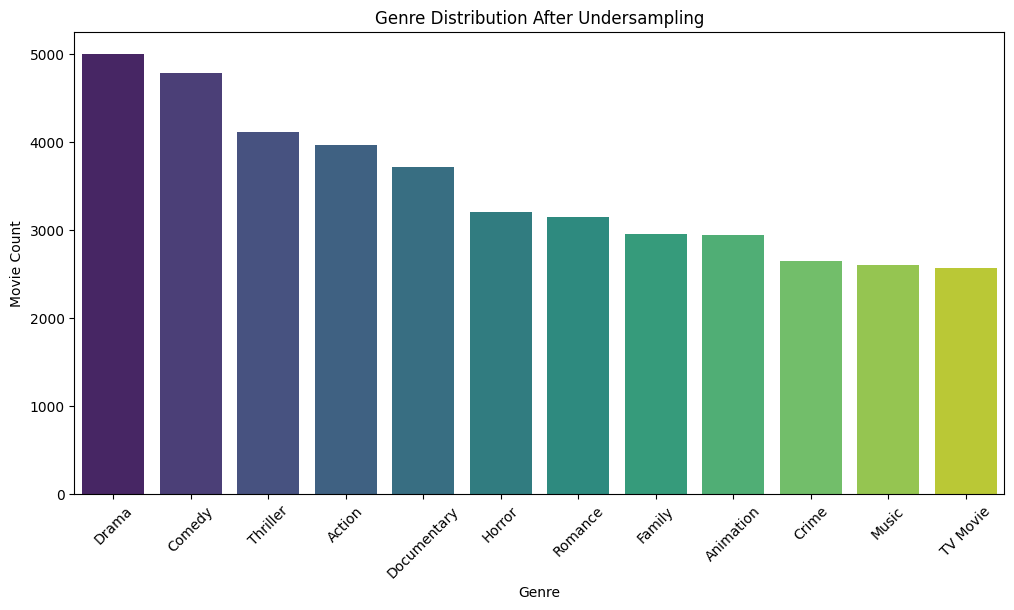

In [ ]:
# Block U3: Plot Genre Distribution After Undersampling

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(x=new_genre_counts_under.index, y=new_genre_counts_under.values, palette='viridis')
plt.title("Genre Distribution After Undersampling")
plt.xlabel("Genre")
plt.ylabel("Movie Count")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Block U7: Save the Undersampled Dataset to CSV for Model Training

import os

# Define the new file path in your custom base folder
undersampled_csv_path = os.path.join('/content/drive/MyDrive/Tmdb_posters_custom', 'undersampled_movie_metadata.csv')

# Save the undersampled DataFrame (df_under) to a CSV file without the index column
df_under.to_csv(undersampled_csv_path, index=False)

print(f"Undersampled movie metadata CSV saved to: {undersampled_csv_path}")


Undersampled movie metadata CSV saved to: /content/drive/MyDrive/Tmdb_posters_custom/undersampled_movie_metadata.csv


In [ ]:
# Block P1: Poster Metadata Quality

import os

# Count total records and those with non-null poster_file
total_posters = len(df_final)
non_null_posters = df_final['poster_file'].notnull().sum()

# Check file existence for a sample (or all) poster_file paths
df_final['poster_exists'] = df_final['poster_file'].apply(lambda x: os.path.exists(x) if pd.notnull(x) else False)
files_exist = df_final['poster_exists'].sum()

print("Poster Metadata Quality:")
print(f"Total records: {total_posters}")
print(f"Non-null poster_file entries: {non_null_posters}")
print(f"Poster files found on disk: {files_exist}")


Poster Metadata Quality:
Total records: 27901
Non-null poster_file entries: 27901
Poster files found on disk: 27901


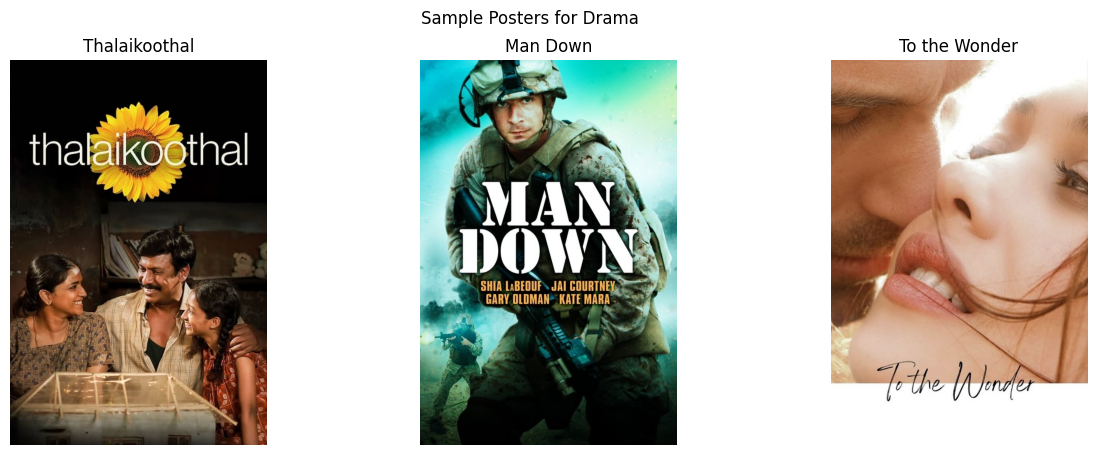

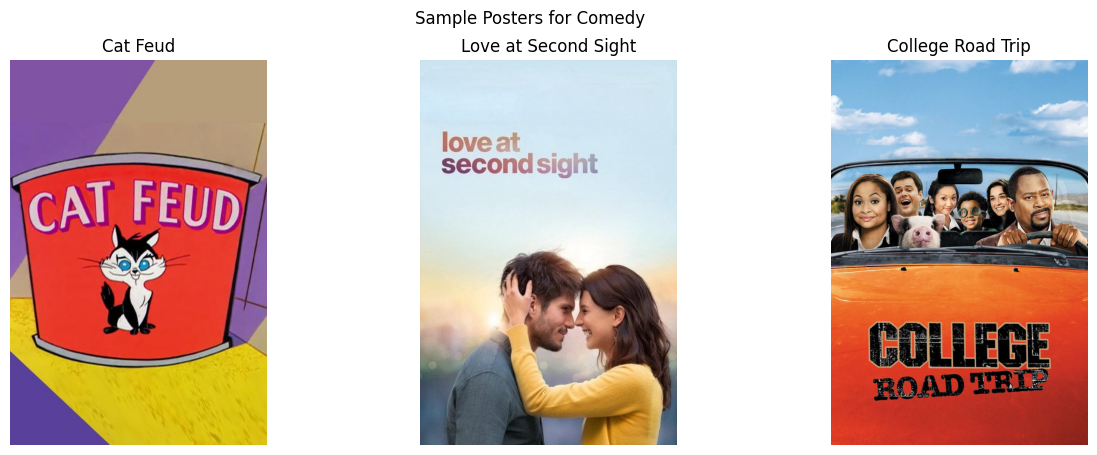

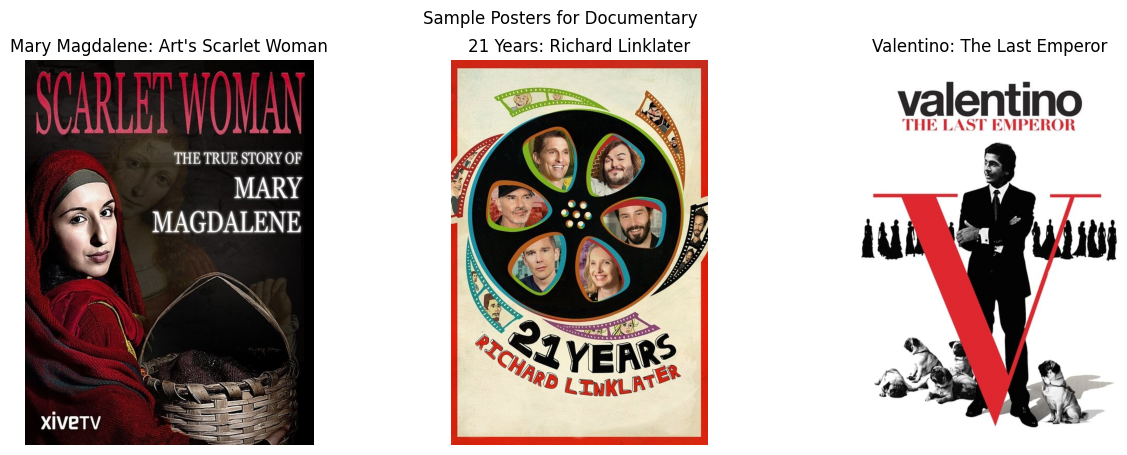

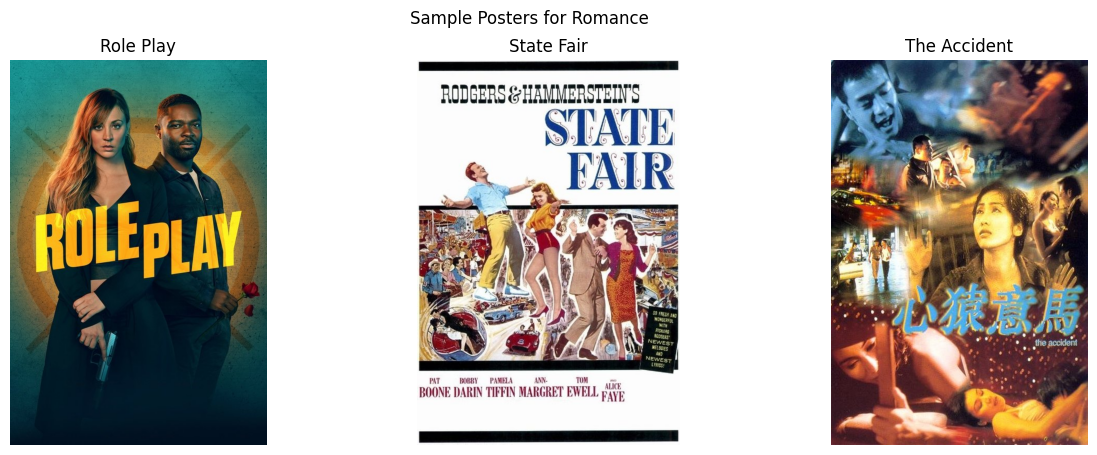

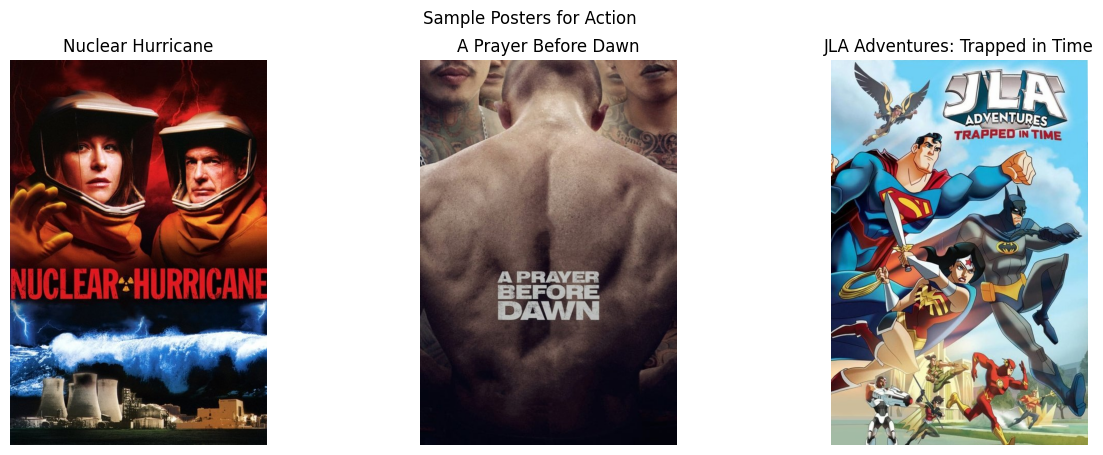

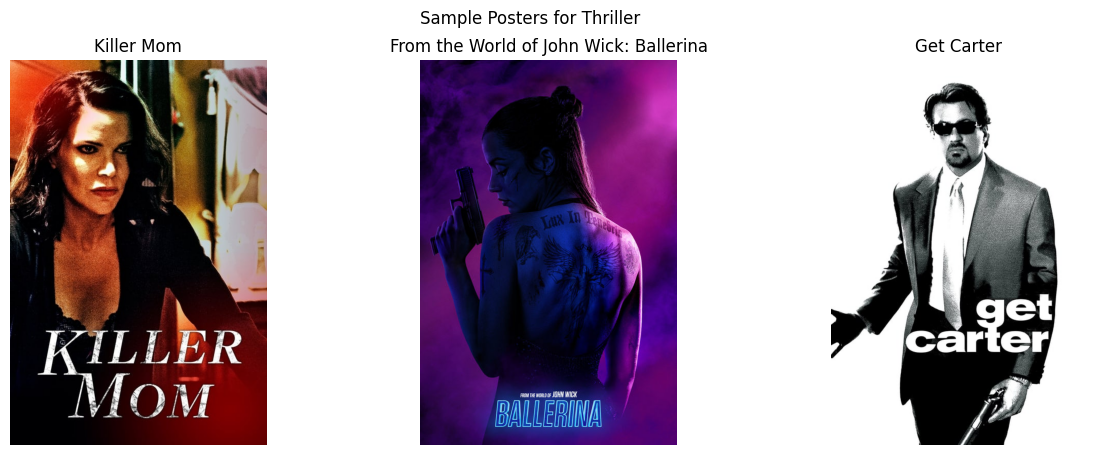

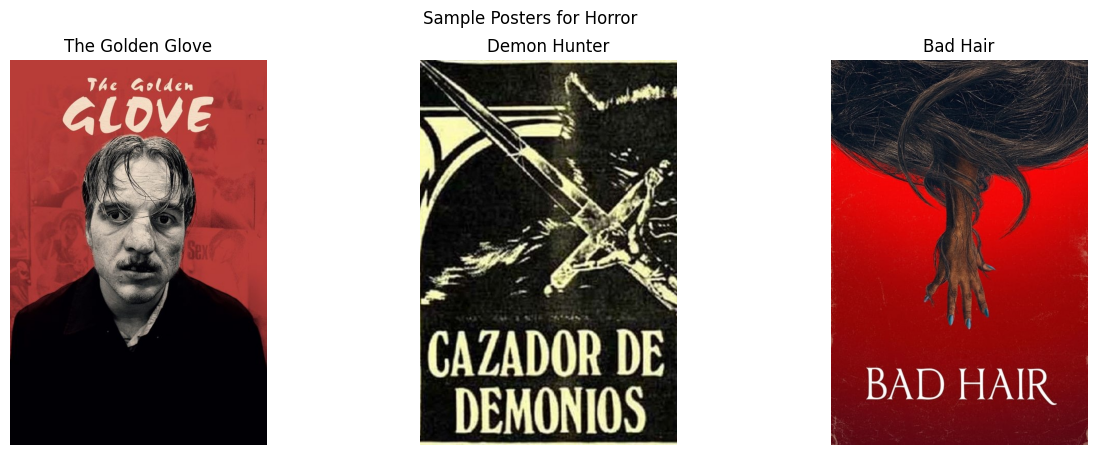

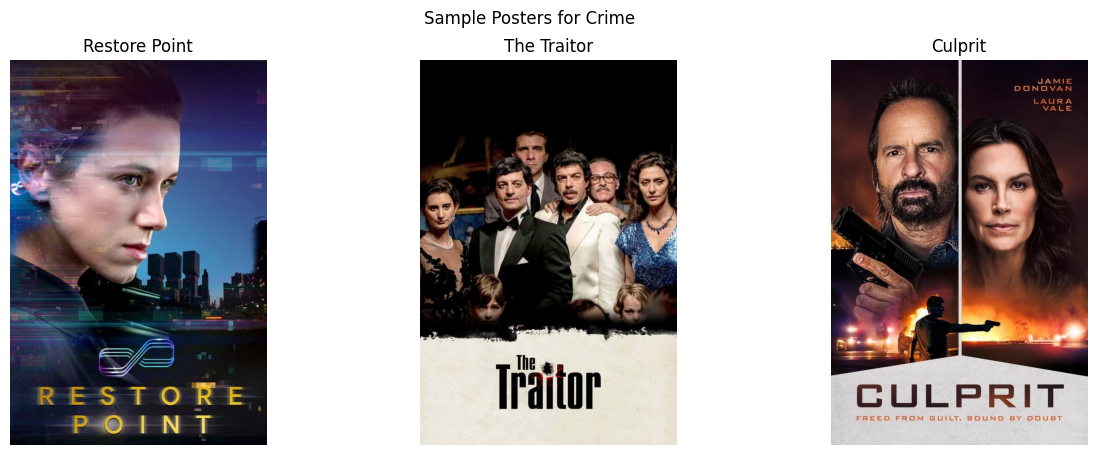

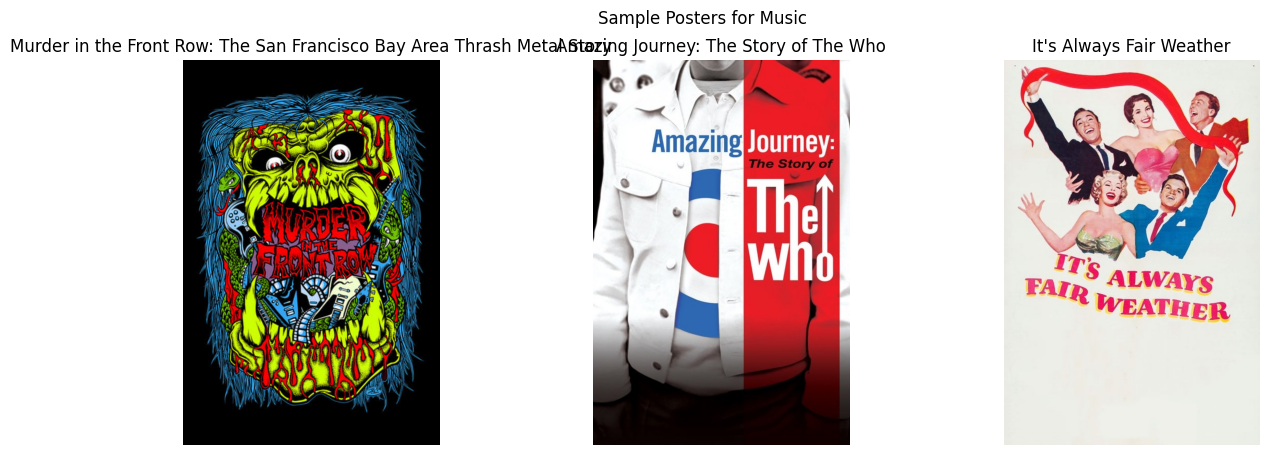

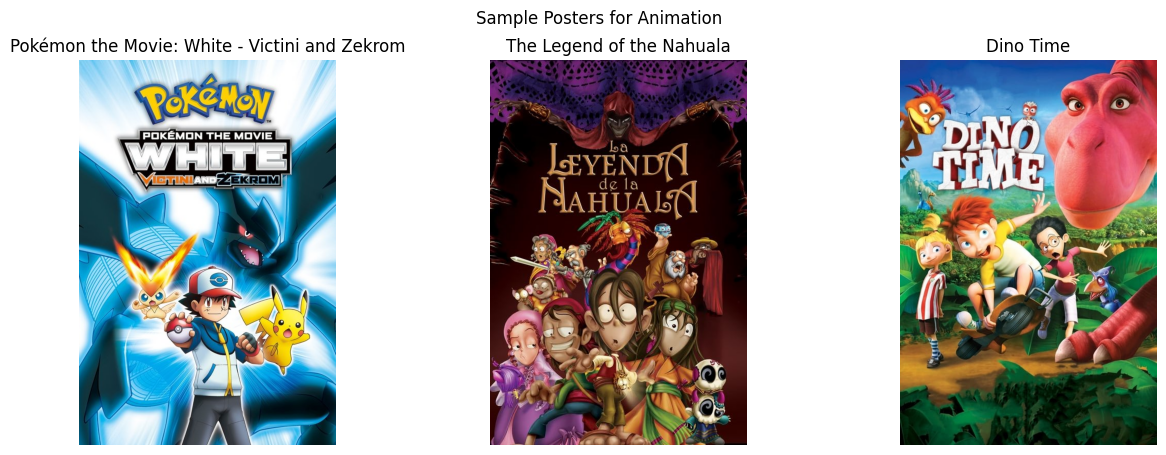

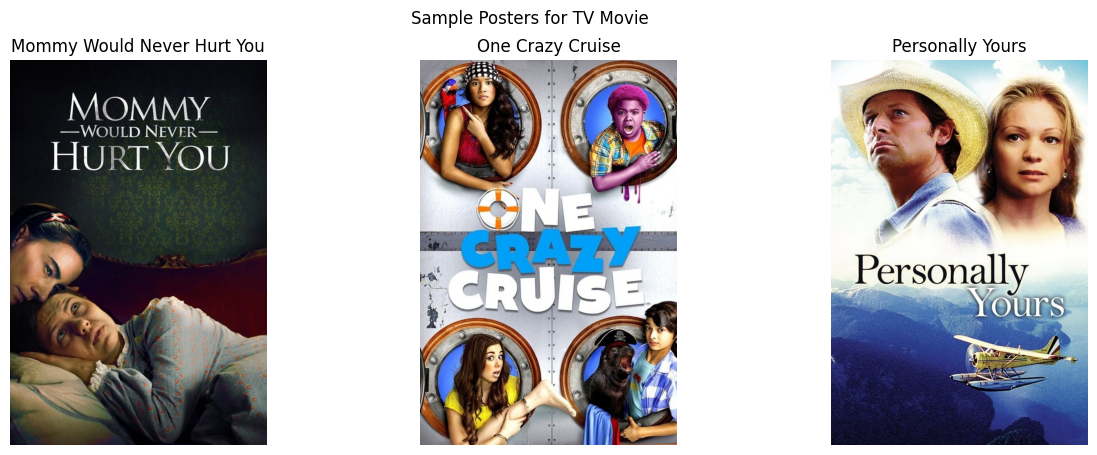

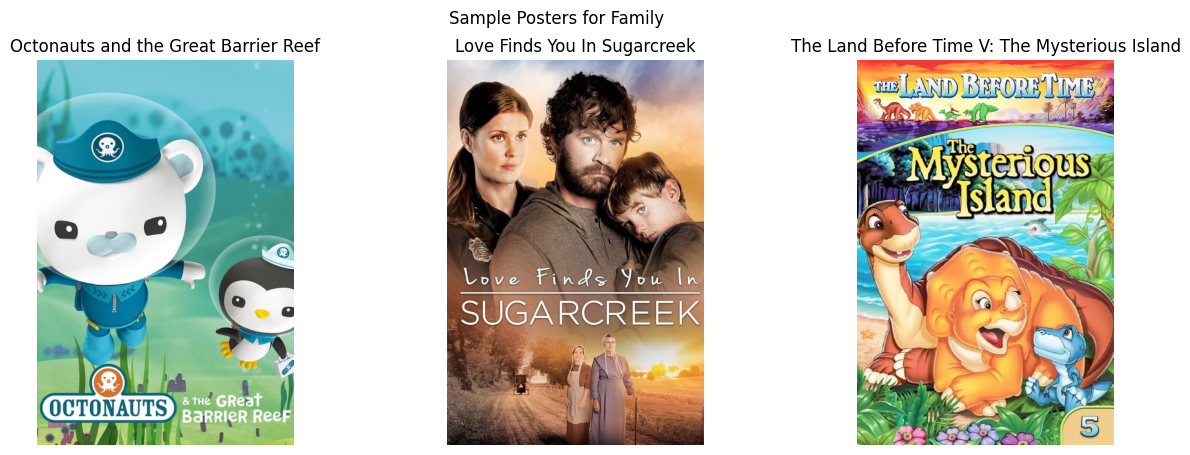

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def display_posters_for_genre(genre, num_samples=3):
    movies_with_genre = df_final[df_final[genre] == 1]
    samples = movies_with_genre.sample(min(num_samples, len(movies_with_genre)))
    fig, axes = plt.subplots(1, len(samples), figsize=(15,5))
    if len(samples) == 1:
        axes = [axes]  # Ensure axes is iterable for single sample
    for i, (idx, row) in enumerate(samples.iterrows()):
        poster_path = row['poster_file']
        if poster_path and os.path.exists(poster_path):
            img = mpimg.imread(poster_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(row['title'])
        else:
            axes[i].text(0.5, 0.5, 'No poster', ha='center', va='center')
    plt.suptitle(f'Sample Posters for {genre}')
    plt.savefig(f'posters_{genre}.png')

for genre in common_genres:
    display_posters_for_genre(genre)

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
"ADD HERE"

'ADD HERE'

In [ ]:
from google.colab import drive
import os
import torch
from torchvision import models

# Define paths
base_dataset_dir = '/content/drive/MyDrive/Tmdb_posters_custom'
csv_path = os.path.join(base_dataset_dir, 'undersampled_movie_metadata.csv')
poster_folder = os.path.join(base_dataset_dir, 'movie_posters')
embeddings_path = os.path.join(base_dataset_dir, 'poster_embeddings.pt')

# Verify CSV exists
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at {csv_path}")

# Load pre-trained EfficientNet-B0 for embedding extraction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet = models.efficientnet_b0(weights="IMAGENET1K_V1").to(device)
efficientnet.eval()

# Create feature extractor (remove classifier to get 1280-dimensional embeddings)
feature_extractor = torch.nn.Sequential(*list(efficientnet.children())[:-1])

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 45.4MB/s]


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os
import torch
import requests
from io import BytesIO

class PosterDataset(Dataset):
    def __init__(self, df, base_folder, transform=None, embeddings_path=None):
        self.df = df.reset_index(drop=True)
        self.base_folder = base_folder
        self.transform = transform
        self.embeddings_path = embeddings_path
        self.genres = ['Drama', 'Comedy', 'Documentary', 'Romance', 'Action', 'Thriller',
                       'Horror', 'Crime', 'Music', 'Animation', 'TV Movie', 'Family']
        self.failed_images = 0
        if embeddings_path and os.path.exists(embeddings_path):
            self.embeddings = torch.load(embeddings_path)
            if len(self.embeddings) != len(self.df):
                raise ValueError(f"Embedding size ({len(self.embeddings)}) does not match dataset size ({len(self.df)})")
        # Verify genre columns
        if not all(g in df.columns for g in self.genres):
            raise ValueError(f"Missing genre columns in DataFrame: {set(self.genres) - set(df.columns)}")
        if len([col for col in df.columns if col in self.genres]) != 12:
            raise ValueError(f"Expected 12 genre columns, found {len([col for col in df.columns if col in self.genres])}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        poster_path = os.path.join(self.base_folder, self.df.iloc[idx]['poster_path'])
        poster_url = self.df.iloc[idx].get('poster_url', '')
        labels = self.df.iloc[idx][self.genres].values.astype(float)
        if len(labels) != 12:
            raise ValueError(f"Label size ({len(labels)}) does not match expected 12 genres at index {idx}")

        if self.embeddings is not None:
            # Return pre-computed embedding
            embedding = self.embeddings[idx]
            return embedding, torch.tensor(labels, dtype=torch.float32)
        else:
            # Load image for embedding extraction
            try:
                # Try loading from poster_path
                if os.path.exists(poster_path):
                    image = Image.open(poster_path).convert('RGB')
                else:
                    # Fall back to poster_url
                    if poster_url:
                        response = requests.get(poster_url, timeout=5)
                        response.raise_for_status()
                        image = Image.open(BytesIO(response.content)).convert('RGB')
                    else:
                        raise ValueError("No valid poster_path or poster_url")
            except Exception as e:
                print(f"Failed to load image {poster_path} or URL {poster_url}: {e}")
                self.failed_images += 1
                image = Image.new('RGB', (224, 224), (0, 0, 0))
                labels = [0] * len(self.genres)
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(labels, dtype=torch.float32)

In [ ]:
# Block 3

In [ ]:
import pandas as pd
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from sklearn.preprocessing import MultiLabelBinarizer
import torch

# Load and filter dataset
df = pd.read_csv(csv_path)
df = df[df['poster_path'].notna() & df['poster_path'].apply(lambda x: isinstance(x, str))]
print(f"Raw dataset size: {len(df)}")

# Process genres
def safe_convert(x):
    try:
        return eval(x) if isinstance(x, str) else []
    except:
        return []
df['genres'] = df['genres'].apply(safe_convert)
common_genres = ['Drama', 'Comedy', 'Documentary', 'Romance', 'Action', 'Thriller',
                 'Horror', 'Crime', 'Music', 'Animation', 'TV Movie', 'Family']
df['has_common_genre'] = df['genres'].apply(lambda x: any(g in common_genres for g in x))
df = df[df['has_common_genre']].drop(columns=['has_common_genre'])
print(f"Filtered dataset size: {len(df)}")

# Verify genre distribution
genre_counts = {}
for genre_list in df['genres']:
    for g in genre_list:
        if g in common_genres:
            genre_counts[g] = genre_counts.get(g, 0) + 1
print("Filtered genre counts:", genre_counts)

# One-hot encode genres
mlb = MultiLabelBinarizer(classes=common_genres)
genre_labels = mlb.fit_transform(df['genres'])
df_genres = pd.DataFrame(genre_labels, columns=mlb.classes_, index=df.index)
# Drop any existing genre columns and add only the 12 common genres
df = df.drop(columns=[col for col in df.columns if col in common_genres], errors='ignore')
df = pd.concat([df, df_genres], axis=1)

# Verify genre columns and counts
if not all(g in df.columns for g in common_genres):
    raise ValueError("Genre columns missing in DataFrame.")
if len([col for col in df.columns if col in common_genres]) != 12:
    raise ValueError(f"Expected 12 genre columns, found {len([col for col in df.columns if col in common_genres])}")
print("One-hot encoded genre counts:", df[common_genres].sum().to_dict())

# Check for movies with only non-common genres
non_common_only = df[df[common_genres].sum(axis=1) == 0]
if len(non_common_only) > 0:
    print(f"Warning: {len(non_common_only)} movies have only non-common genres.")
    df = df[df[common_genres].sum(axis=1) > 0]
    print(f"Filtered dataset size after removing non-common genres: {len(df)}")

# Define transforms for embedding extraction
extract_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Extract embeddings if not already saved
if not os.path.exists(embeddings_path):
    print("Extracting embeddings...")
    extract_dataset = PosterDataset(df, poster_folder, transform=extract_transforms, embeddings_path=None)
    extract_loader = DataLoader(extract_dataset, batch_size=32, shuffle=False, num_workers=1, pin_memory=True)

    all_embeddings = []
    with torch.no_grad():
        for images, _ in extract_loader:
            images = images.to(device, non_blocking=True)
            embeddings = feature_extractor(images)  # Shape: (batch_size, 1280, 1, 1)
            embeddings = embeddings.squeeze(-1).squeeze(-1)  # Shape: (batch_size, 1280)
            all_embeddings.append(embeddings.cpu())
    all_embeddings = torch.cat(all_embeddings)
    torch.save(all_embeddings, embeddings_path)
    print(f"Embeddings saved to {embeddings_path}")
    print(f"Failed images during embedding extraction: {extract_dataset.failed_images}")
else:
    print(f"Embeddings loaded from {embeddings_path}")

# Create dataset with embeddings
full_dataset = PosterDataset(df, poster_folder, transform=None, embeddings_path=embeddings_path)

# Split dataset
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Training set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")

Raw dataset size: 20530
Filtered dataset size: 20530
Filtered genre counts: {'Romance': 3146, 'Comedy': 4778, 'Drama': 4998, 'Crime': 2648, 'Thriller': 4115, 'Action': 3964, 'Family': 2953, 'Animation': 2946, 'Documentary': 3718, 'Music': 2599, 'Horror': 3208, 'TV Movie': 2569}
One-hot encoded genre counts: {'Drama': 4998, 'Comedy': 4778, 'Documentary': 3718, 'Romance': 3146, 'Action': 3964, 'Thriller': 4115, 'Horror': 3208, 'Crime': 2648, 'Music': 2599, 'Animation': 2946, 'TV Movie': 2569, 'Family': 2953}


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Adventure', 'Fantasy', 'History', 'Mystery', 'Science Fiction', 'War', 'Western'] will be ignored
  warnings.warn(


Embeddings loaded from /content/drive/MyDrive/Tmdb_posters_custom/poster_embeddings.pt
Training set size: 16424, Validation set size: 4106


In [ ]:
# Validate labels
sample_dataset = PosterDataset(df, poster_folder, transform=None, embeddings_path=embeddings_path)
for i in range(5):
    _, labels = sample_dataset[i]
    print(f"Sample {i} labels: {labels.numpy()}, Shape: {labels.shape}")

# Check embedding validity
embeddings = torch.load(embeddings_path)
print(f"Embedding shape: {embeddings.shape}, Expected: [20530, 1280]")
print(f"Non-zero embeddings: {(embeddings != 0).any(dim=1).sum().item()}/{len(embeddings)}")

# # Check failed images (if not already printed)
# if 'extract_dataset' in globals():
#     print(f"Failed images: {extract_dataset.failed_images}")

Sample 0 labels: [1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], Shape: torch.Size([12])
Sample 1 labels: [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], Shape: torch.Size([12])
Sample 2 labels: [0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.], Shape: torch.Size([12])
Sample 3 labels: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], Shape: torch.Size([12])
Sample 4 labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.], Shape: torch.Size([12])
Embedding shape: torch.Size([20530, 1280]), Expected: [20530, 1280]
Non-zero embeddings: 20530/20530


In [ ]:
!pip install torchmetrics

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from torchmetrics.classification import MultilabelExactMatch, MultilabelPrecision, MultilabelRecall, MultilabelF1Score

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1, pin_memory=True)

# Modify EfficientNet-B0 to accept embeddings
class EmbeddingEfficientNet(nn.Module):
    def __init__(self, num_classes=12):
        super(EmbeddingEfficientNet, self).__init__()
        base_model = models.efficientnet_b0(weights="IMAGENET1K_V1")
        self.features = torch.nn.Sequential(*list(base_model.children())[:-2])  # Up to global avg pooling
        self.classifier = nn.Sequential(
            nn.Linear(1280, 1280),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        if x.dim() == 2:  # (batch_size, 1280)
            return self.classifier(x)
        else:
            x = self.features(x)
            x = x.squeeze(-1).squeeze(-1)  # Shape: (batch_size, 1280)
            return self.classifier(x)

# Initialize model
model = EmbeddingEfficientNet(num_classes=12).to(device)

# Compute class weights based on genre frequencies (from Block 3 output)
genre_counts = {'Romance': 3146, 'Comedy': 4778, 'Drama': 4998, 'Crime': 2648, 'Thriller': 4115,
                'Action': 3964, 'Family': 2953, 'Animation': 2946, 'Documentary': 3718, 'Music': 2599,
                'Horror': 3208, 'TV Movie': 2569}
total_samples = 20530
pos_weights = torch.tensor([total_samples / (count + 1e-6) for count in genre_counts.values()], device=device)

# Define loss, optimizer, and scheduler
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = optim.Adam([
    {'params': model.features.parameters(), 'lr':3e-5},  # Fine-tune features
    {'params': model.classifier.parameters(), 'lr': 5e-3}  # Higher LR for classifier
], weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Initialize GradScaler for GPU
scaler = torch.amp.GradScaler('cpu') if device.type == 'cpu' else 'cpu'

# Initialize metric storage
train_accs = []
val_accs = []
train_precs = []
val_precs = []
train_recs = []
val_recs = []
train_f1s = []
val_f1s = []

# Initialize metric objects
subset_acc = MultilabelExactMatch(num_labels=12).to(device)
precision = MultilabelPrecision(num_labels=12, average='micro').to(device)
recall = MultilabelRecall(num_labels=12, average='micro').to(device)
f1 = MultilabelF1Score(num_labels=12, average='micro').to(device)
# Per-genre F1 for debugging
genre_f1 = MultilabelF1Score(num_labels=12, average='none').to(device)

# Training parameters
num_epochs = 10
best_val_loss = float('inf')
patience = 5
patience_counter = 0
min_delta = 0.0005  # Minimum improvement for early stopping

print(f"Training on {device} with {len(train_dataset)} training samples, {len(val_dataset)} validation samples")

KeyboardInterrupt: 

In [ ]:
import time
from tqdm import tqdm
import torch

# Training loop
try:
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0

        # Reset metrics
        subset_acc.reset()
        precision.reset()
        recall.reset()
        f1.reset()
        genre_f1.reset()

        train_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
        for batch_idx, (embeddings, labels) in enumerate(train_bar):
            embeddings, labels = embeddings.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)

            # Mixed precision training
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(embeddings)
                loss = criterion(outputs, labels.float())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * embeddings.size(0)

            # Debug model outputs (first batch of first epoch)
            if epoch == 0 and batch_idx == 0:
                with torch.no_grad():
                    sigmoid_outputs = torch.sigmoid(outputs)
                    print(f"Sample sigmoid outputs: {sigmoid_outputs[:5]}")
                    print(f"Sample labels: {labels[:5]}")
                    print(f"Non-zero labels: {labels.sum().item()} in batch")

            # Update metrics with adjusted threshold
            with torch.no_grad():
                # preds = torch.sigmoid(outputs) > 0.1  # Lowered threshold
                preds = torch.sigmoid(outputs) > 0.05
                subset_acc.update(preds, labels)
                precision.update(preds, labels)
                recall.update(preds, labels)
                f1.update(preds, labels)
                genre_f1.update(preds, labels)

            train_bar.set_postfix(loss=loss.item())

            # Clear memory
            del embeddings, labels, outputs, preds, loss
            torch.cuda.empty_cache()

        epoch_loss = running_loss / len(train_dataset)

        # Store training metrics
        train_accs.append(subset_acc.compute().item())
        train_precs.append(precision.compute().item())
        train_recs.append(recall.compute().item())
        train_f1s.append(f1.compute().item())

        # Validation
        model.eval()
        val_running_loss = 0.0

        # Reset metrics
        subset_acc.reset()
        precision.reset()
        recall.reset()
        f1.reset()
        genre_f1.reset()

        with torch.no_grad():
            for embeddings, labels in val_loader:
                embeddings, labels = embeddings.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                with torch.amp.autocast(device_type='cuda'):
                    outputs = model(embeddings)
                    loss = criterion(outputs, labels.float())
                val_running_loss += loss.item() * embeddings.size(0)

                preds = torch.sigmoid(outputs) > 0.1  # Lowered threshold
                subset_acc.update(preds, labels)
                precision.update(preds, labels)
                recall.update(preds, labels)
                f1.update(preds, labels)
                genre_f1.update(preds, labels)

                del embeddings, labels, outputs, preds, loss
                torch.cuda.empty_cache()

        val_loss = val_running_loss / len(val_dataset)

        # Store validation metrics
        val_accs.append(subset_acc.compute().item())
        val_precs.append(precision.compute().item())
        val_recs.append(recall.compute().item())
        val_f1s.append(f1.compute().item())

        # Print per-genre F1-scores (first epoch and every 5th)
        if epoch == 0 or (epoch + 1) % 5 == 0:
            genre_f1_scores = genre_f1.compute().cpu().numpy()
            print(f"Per-genre Val F1: {dict(zip(common_genres, genre_f1_scores))}")

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} - {epoch_time:.2f}s - Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f} - Val F1: {val_f1s[-1]:.4f}")

        # Early stopping
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), '/content/drive/MyDrive/model_checkpoint.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

        scheduler.step()

    print("Training complete!")
except Exception as e:
    print(f"Training interrupted with error: {str(e)}")
    raise

Epoch [1/10]:   0%|          | 0/514 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch [1/10]:   1%|          | 3/514 [00:00<01:19,  6.40it/s, loss=1.57]

Sample sigmoid outputs: tensor([[0.5226, 0.5014, 0.4757, 0.4853, 0.4846, 0.5140, 0.4995, 0.4510, 0.4807,
         0.5138, 0.5085, 0.4858],
        [0.5027, 0.4978, 0.4902, 0.4817, 0.5039, 0.5082, 0.4847, 0.4898, 0.5006,
         0.4953, 0.5087, 0.4919],
        [0.4884, 0.4873, 0.5028, 0.5097, 0.4834, 0.4993, 0.4983, 0.4543, 0.5058,
         0.5122, 0.5119, 0.5011],
        [0.5172, 0.4966, 0.4829, 0.4889, 0.5065, 0.5305, 0.4842, 0.4561, 0.4846,
         0.5045, 0.5081, 0.4713],
        [0.5176, 0.5128, 0.4914, 0.4814, 0.5144, 0.4935, 0.4772, 0.4576, 0.4909,
         0.5026, 0.5422, 0.4990]])
Sample labels: tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]])
Non-zero labels: 61.0 in batch


Epoch [1/10]: 100%|██████████| 514/514 [00:54<00:00,  9.41it/s, loss=1.4]


Per-genre Val F1: {'Drama': np.float32(0.39169604), 'Comedy': np.float32(0.37579113), 'Documentary': np.float32(0.31167763), 'Romance': np.float32(0.26531476), 'Action': np.float32(0.30854788), 'Thriller': np.float32(0.32715422), 'Horror': np.float32(0.26384777), 'Crime': np.float32(0.2255834), 'Music': np.float32(0.23245803), 'Animation': np.float32(0.25313762), 'TV Movie': np.float32(0.22673288), 'Family': np.float32(0.25239414)}
Epoch 1/10 - 58.58s - Train Loss: 1.2817 - Val Loss: 1.2654 - Val F1: 0.2879


Epoch [2/10]: 100%|██████████| 514/514 [00:25<00:00, 19.93it/s, loss=1.28]


Epoch 2/10 - 29.69s - Train Loss: 1.2717 - Val Loss: 1.3367 - Val F1: 0.2879


Epoch [3/10]: 100%|██████████| 514/514 [00:27<00:00, 18.69it/s, loss=1.27]


Epoch 3/10 - 31.75s - Train Loss: 1.2708 - Val Loss: 1.2644 - Val F1: 0.2879


Epoch [4/10]: 100%|██████████| 514/514 [02:48<00:00,  3.06it/s, loss=1.4]


Epoch 4/10 - 211.86s - Train Loss: 1.2727 - Val Loss: 1.2651 - Val F1: 0.2879


Epoch [5/10]: 100%|██████████| 514/514 [03:21<00:00,  2.55it/s, loss=1.29]


Per-genre Val F1: {'Drama': np.float32(0.39169604), 'Comedy': np.float32(0.37579113), 'Documentary': np.float32(0.31167763), 'Romance': np.float32(0.26531476), 'Action': np.float32(0.30854788), 'Thriller': np.float32(0.32715422), 'Horror': np.float32(0.26384777), 'Crime': np.float32(0.2255834), 'Music': np.float32(0.23245803), 'Animation': np.float32(0.25313762), 'TV Movie': np.float32(0.22673288), 'Family': np.float32(0.25239414)}
Epoch 5/10 - 246.69s - Train Loss: 1.2719 - Val Loss: 1.2617 - Val F1: 0.2879


Epoch [6/10]: 100%|██████████| 514/514 [03:41<00:00,  2.33it/s, loss=1.24]


Epoch 6/10 - 276.62s - Train Loss: 1.2625 - Val Loss: 1.2610 - Val F1: 0.2879


Epoch [7/10]: 100%|██████████| 514/514 [04:00<00:00,  2.14it/s, loss=1.22]


Epoch 7/10 - 292.83s - Train Loss: 1.2625 - Val Loss: 1.2624 - Val F1: 0.2879


Epoch [8/10]: 100%|██████████| 514/514 [04:06<00:00,  2.08it/s, loss=1.29]


Epoch 8/10 - 299.62s - Train Loss: 1.2640 - Val Loss: 1.2614 - Val F1: 0.2879


Epoch [9/10]: 100%|██████████| 514/514 [04:03<00:00,  2.11it/s, loss=1.33]


Epoch 9/10 - 295.94s - Train Loss: 1.2676 - Val Loss: 1.2610 - Val F1: 0.2879


Epoch [10/10]: 100%|██████████| 514/514 [03:52<00:00,  2.21it/s, loss=1.08]


Per-genre Val F1: {'Drama': np.float32(0.39169604), 'Comedy': np.float32(0.37579113), 'Documentary': np.float32(0.31167763), 'Romance': np.float32(0.26531476), 'Action': np.float32(0.30854788), 'Thriller': np.float32(0.32715422), 'Horror': np.float32(0.26384777), 'Crime': np.float32(0.2255834), 'Music': np.float32(0.23245803), 'Animation': np.float32(0.25313762), 'TV Movie': np.float32(0.22673288), 'Family': np.float32(0.25239414)}
Epoch 10/10 - 284.17s - Train Loss: 1.2674 - Val Loss: 1.2633 - Val F1: 0.2879
Training complete!


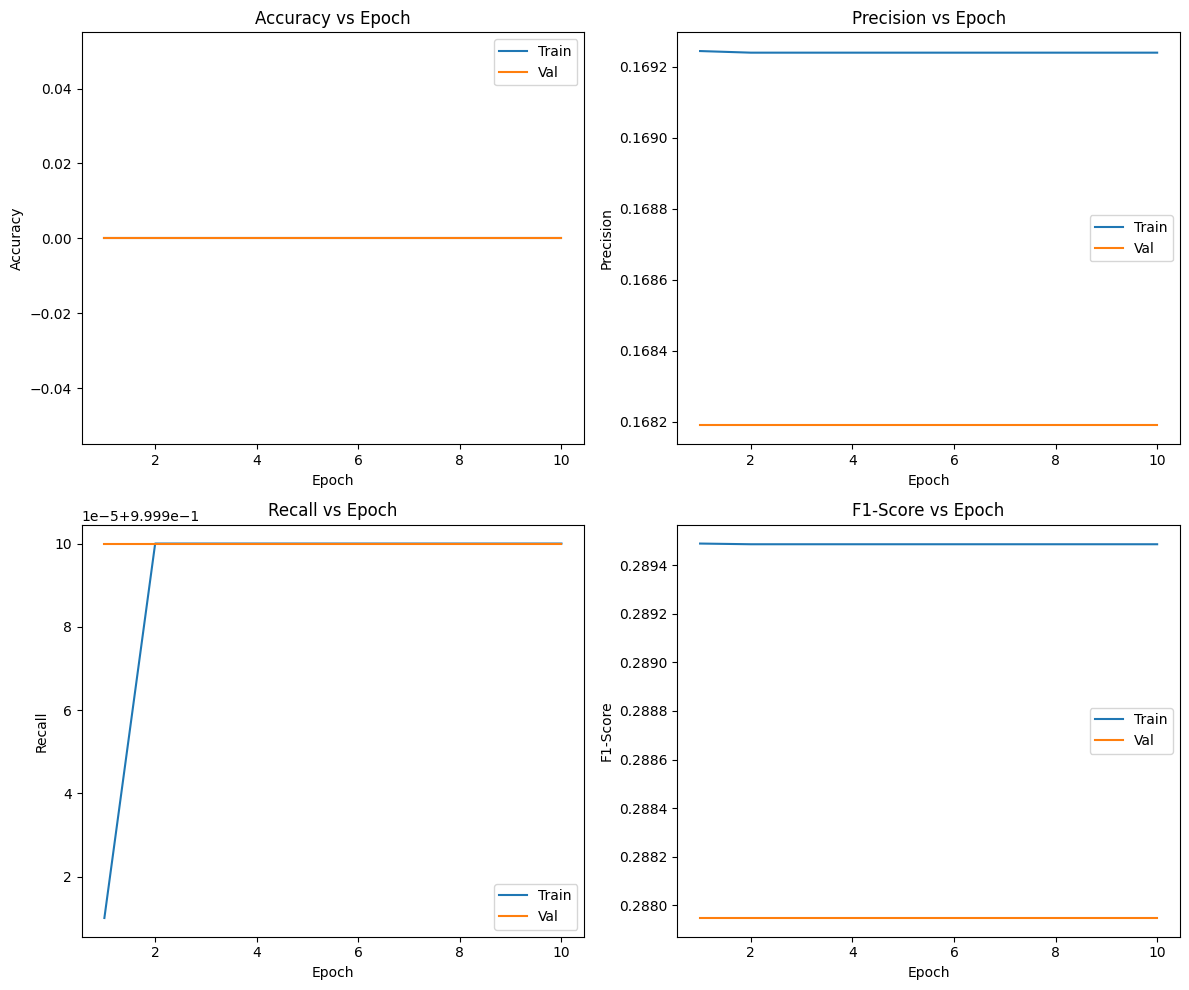

In [ ]:
import matplotlib.pyplot as plt

# Plotting metrics
epochs = range(1, len(train_accs) + 1)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_accs, label='Train')
plt.plot(epochs, val_accs, label='Val')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_precs, label='Train')
plt.plot(epochs, val_precs, label='Val')
plt.title('Precision vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_recs, label='Train')
plt.plot(epochs, val_recs, label='Val')
plt.title('Recall vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1s, label='Train')
plt.plot(epochs, val_f1s, label='Val')
plt.title('F1-Score vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()

plt.tight_layout()
plt.savefig('metrics_vs_epoch.png')
plt.show()